# IEEE-CIS Fraud Detection

In this notebook, we will work on the IEEE-CIS Fraud Detection competition. Our aim is to train a machine learning model to predict the probability that an online transaction is fraudulent.   
The data is broken into two files: identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

Categorical Features - Transaction:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Categorical Features - Identity:
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). 
Agenda:  
1. Importing Necessary Libraries 
2. Data Loading 
3. Understanding, and Cleaning 
4. Data Preprocessing 
5. ML Modeling
6. Conclusion

In [14]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import gc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from matplotlib.ticker import FuncFormatter


import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

plt.style.use('dark_background')

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")

# 1. Data download and review

In [2]:
# Loading data

t_id = pd.read_csv('train_identity.csv')
t_tran = pd.read_csv('train_transaction.csv')

In [3]:
t_id.head(3)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [4]:
t_tran.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# We combine data by TransactionID

train = t_tran.merge(t_id, on = ['TransactionID'], how = 'left')

In [6]:
del t_id
del t_tran

gc.collect

<function gc.collect(generation=2)>

In [8]:
# Due to the large memory costs for processing the dataset, we will reduce the data to 150 thousand rows

train = train.truncate(after=150000)

In [9]:
# Reduce memory usage

def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(train)

Initial memory usage of dataframe is 657.04 MB/0.64 GB
Memory usage after optimization is: 127.47 MB/0.12 GB
Decreased by 80.6%


In [10]:
# Check the number of passes

mv = train.isnull().sum().to_frame()
mv_p = (train.isnull().sum()/train.isnull().count()*100)

pd.concat([mv, mv_p], axis=1, keys=['Missing values', 'Missing values %']).transpose()

,,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Missing values,0,0.0,0.0,0.0,0.0,0.0,0.0,2034.000000,3.000,8.000000,791.00000,...,90217.000000,107061.000000,110174.000000,106993.000000,90031.000000,90031.000000,90031.000000,90031.000000,90153.000000,96316.000000
Missing values %,0,0.0,0.0,0.0,0.0,0.0,0.0,1.355991,0.002,0.005333,0.52733,...,60.144266,71.373524,73.448844,71.328191,60.020267,60.020267,60.020267,60.020267,60.101599,64.210239


In [11]:
target_count = pd.DataFrame(train['isFraud'].value_counts())
target_percent = pd.DataFrame(train['isFraud'].value_counts()/len(train))

pd.concat([target_count, target_percent], axis=1, keys=['Count', 'Percent'])

,Count,Percent
,count,count
isFraud,,
0,146031,0.973534
1,3970,0.026466


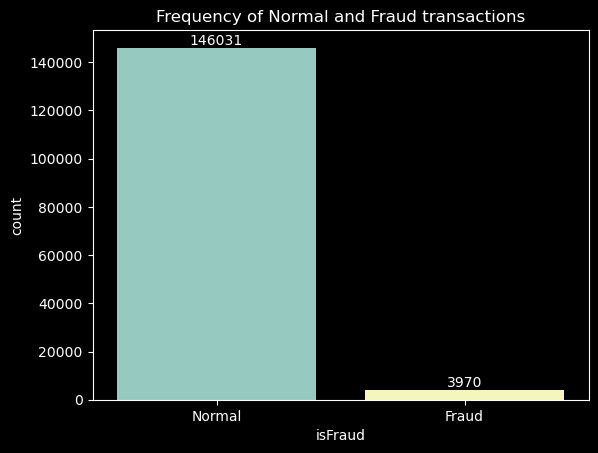

In [15]:
ax = sns.countplot(data = train, x='isFraud')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xticklabels(['Normal','Fraud'])
    
plt.title('Frequency of Normal and Fraud transactions')
plt.show()

We are observing unbalanced data, which is not suitable for training in its current form. In the future, we will perform an oversampling procedure based on the attribute "isFraud".

# 2. Data Preprocessing 

In [16]:
# Selecting categorical features

category_features = ['ProductCD','card4','card6', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_15',
                'id_16','id_23','id_27','id_28','id_29','id_30','id_31',
                'id_33','id_34','id_35','id_36','id_37','id_38']

In [17]:
# Selecting categorical features

numerical_features = [i for i in train.columns.values[2:] if i not in category_features]

In [18]:
# Let's look at the number of categorical and numeric features

print('Number of categorical features:', len(category_features))
print('Number of numerical features:', len(numerical_features))

Number of categorical features: 31
Number of numerical features: 401


## 2.1 OHE

In [19]:
scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown='ignore')

transformed = ohe.fit_transform(train[category_features])
transformed_df = pd.DataFrame(transformed.toarray(), columns=ohe.get_feature_names_out(category_features))
train = pd.concat([train.drop(category_features, axis=1), transformed_df], axis=1)

In [20]:
train.shape

(150001, 2010)

## 2.2 Data Oversampling

In [21]:
# Scaling numerical features

scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [22]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_35_nan,id_36_F,id_36_T,id_36_nan,id_37_F,id_37_T,id_37_nan,id_38_F,id_38_T,id_38_nan
0,2987000,0,-1.839114,-0.297226,0.825589,NaN,-0.303941,-1.427279,0.230320,0.121856,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2987001,0,-1.839113,-0.494179,-1.446489,0.214509,-0.303941,-2.408158,0.328050,0.121856,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2987002,0,-1.839029,-0.344594,-1.058420,0.754882,-0.303941,-0.838751,0.376916,0.121856,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2987003,0,-1.838993,-0.389470,1.681051,1.238705,-0.303941,-2.040329,1.803785,0.121856,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2987004,0,-1.838984,-0.389470,-1.092183,0.905684,-0.303941,-2.408158,1.256493,0.121856,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
#del scaler, ohe
#gc.collect

In [24]:
y=train['isFraud']
df_maj = train[y == 0]

df_min = train[y == 1]


y_maj = y[y == 0]
y_min = y[y == 1]


df_min_upsampled = resample(df_min, replace=True,n_samples=len(df_maj),random_state=12345)

train = pd.concat([df_maj, df_min_upsampled])
y_min_upsampled = y_min[df_min_upsampled.index]
y = pd.concat([y_maj, y_min_upsampled])


In [26]:
# fill the blanks

imputer = SimpleImputer(strategy='median')
imputer.fit(train)
X_train = imputer.transform(train)
print(X_train.shape)

(292062, 2010)


# 3. Modeling

In [28]:
y = train['isFraud']

train.drop('isFraud', axis=1, inplace=True)
train.drop('TransactionID', axis=1, inplace=True)

In [29]:
train_X, test_X, train_Y, test_Y = train_test_split(X_train, y, test_size=0.2, stratify=y)

In [30]:
ov_sam = SMOTE(random_state=12345)
ov_sam_df_X, ov_sam_df_y = ov_sam.fit_resample(train_X, train_Y)

## 3.1 KNN

In [31]:
for i in range(1, 10, 2):
    n = KNeighborsClassifier(n_neighbors=i)
    n.fit(train_X, train_Y)
    predict = n.predict(test_X)
print('k= ', i)
print(classification_report(predict, test_Y))

k=  9
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     27210
           1       1.00      0.94      0.97     31203

    accuracy                           0.97     58413
   macro avg       0.97      0.97      0.97     58413
weighted avg       0.97      0.97      0.97     58413



## 3.2 Random Forest

In [38]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
model_rf = rf.fit(train_X, train_Y)
predict_rf = model_rf.predict(test_X)
cr_rf = classification_report(test_Y, predict_rf)
print('\n\n Classification Report\n')
print(cr_rf)



 Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29206
           1       1.00      1.00      1.00     29207

    accuracy                           1.00     58413
   macro avg       1.00      1.00      1.00     58413
weighted avg       1.00      1.00      1.00     58413



## 3.3 XGB

In [35]:
model = XGBClassifier(seed=42, n_estimators=500, max_depth=10, learning_rate=0.2)

model_xgbc = model.fit(train_X, train_Y)
predict_xgbc = model_xgbc.predict(test_X)

cr_xgbc = classification_report(test_Y, predict_xgbc)
print('\n\n Classification Report\n')
print(cr_xgbc)



 Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29206
           1       1.00      1.00      1.00     29207

    accuracy                           1.00     58413
   macro avg       1.00      1.00      1.00     58413
weighted avg       1.00      1.00      1.00     58413



## 3.4 Logistic regression

In [37]:
model = LogisticRegression(random_state=12345)
model_lr = model.fit(train_X, train_Y)
predict_lr = model_lr.predict(test_X)
cr_lr = classification_report(test_Y, predict_lr)
print('\n\n Classification Report\n')
print(cr_lr)



 Classification Report

              precision    recall  f1-score   support

           0       0.64      0.84      0.73     29206
           1       0.77      0.54      0.63     29207

    accuracy                           0.69     58413
   macro avg       0.71      0.69      0.68     58413
weighted avg       0.71      0.69      0.68     58413



# 4. Conclusion

All models have high scores, except for the logistic regression model. Of all the models, Random Forest and XGBoost stand out strongly. It is also worth noting that these models trained faster than KNN. For this task, we will select XGBoost as the best model for accurately identifying fraudulent operations.